# SommelAI: Prediction
## Steven Jiang and Tony DiPadova

In [6]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
from scipy.stats import pearsonr
import statsmodels.api
import numpy as np
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

## Segment the Dataset

In [3]:
df = pd.read_csv("winemag-data_first150k.csv", encoding="utf-8")
df = df.drop(["Unnamed: 0"], axis=1)
# Subset DF to only include rows where price is not NA
finite_price_df = df[np.isfinite(df['price'])]
# Subset DF to inlcude rows where price is less than $200
lower_price_df = finite_price_df[finite_price_df['price'] < 200]

## Tokenize and Clean Descriptions

In [4]:
from nltk.tokenize import RegexpTokenizer
from string import punctuation
from nltk.corpus import stopwords

stop_words = stopwords.words()
stop_words.append('wine')
tokenizer = RegexpTokenizer(r'\w+')
reviews = lower_price_df['description']

cleaned_text = []
words = {}
for review in reviews:
    tokenized_words = tokenizer.tokenize(review)
    cleaned_review = ""
    for word in tokenized_words:
        word = word.lower()
        if word not in stop_words and word not in punctuation:
            if word in words.keys():
                words[word] += 1
            else:
                words[word] = 1
            cleaned_review += word + " "
    cleaned_text.append(cleaned_review)
    
lower_price_df['cleaned_descriptions'] = cleaned_text

/anaconda2/envs/sommelai/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
# Function for plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predicting Price from Description

As previously mentioned, we are looking to replace sommeliers by being able to predict the quality and price of any given wine using a description of the wine. To do so, we look at the dataset of wines that only include wines priced under 200 dollars per bottle, to remove outliers. We approach this issue as a classification task by segmenting the prices into buckets. We create the following price buckets {(0-19), (20-39), (40-59), ..., (180-199)}. 

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
import itertools

In [50]:
# Generate price buckets
lower_price_df['price_bucket'] = lower_price_df['price'] // 20
lower_price_df['price_bucket'] = lower_price_df['price_bucket'].astype(int)

# Split data into training and test sets
X = lower_price_df['cleaned_descriptions']
y = lower_price_df['price_bucket']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

We use a count vectorizor to generate word counts from the descriptions and then use a TFIDF transformer to calculate the term frequency inverse document frequency of the descriptions. TFIDF gives weight to keywords that don't necessarily appear in a large number of the decriptions, but appear in a certain type of description. In other words, we are looking for keywords that are specific to certain price buckets. We use two classifiers, a Multinomal Naive Bayes classifier and a Stochastic Gradient Descent classifier. Finally, we use scikit-learn's GridSeachCV to tune our hyperparameters.

## Multinomial Naive Bayes Classifier

In [12]:
# Define Multinomial Naive Bayes classifier and tune hyperparameters using GridSearchCV
naive_bayes_pipeline = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                    ])

param_grid = [
    {
        'clf__alpha': [0.5, 1.0],
        'clf__fit_prior': [True, False],
    }
]

grid = GridSearchCV(naive_bayes_pipeline, cv=3, n_jobs=1, param_grid=param_grid)
grid.fit(X_train, y_train)
predicted = grid.predict(X_test)

{'clf__alpha': 1.0, 'clf__fit_prior': False}
0.5679044937228676
             precision    recall  f1-score   support

          0       0.68      0.73      0.70     12682
          1       0.54      0.62      0.57     12864
          2       0.39      0.41      0.40      4969
          3       0.37      0.08      0.13      1989
          4       0.27      0.01      0.02       787
          5       0.50      0.00      0.01       318
          6       0.00      0.00      0.00       268
          7       0.00      0.00      0.00       109
          8       0.00      0.00      0.00        66
          9       0.00      0.00      0.00        40

avg / total       0.54      0.57      0.54     34092



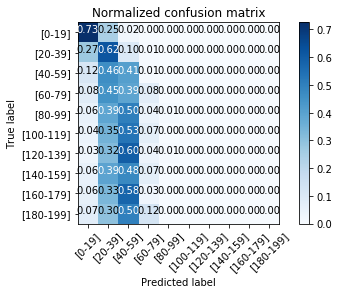

In [13]:
# Evaluate the model
print(grid.best_params_)
# Accuracy
print(np.mean(predicted == y_test))
# Precision and Recall
print(metrics.classification_report(y_test, predicted))

# Plot confusion matrix
cnf_matrix = confusion_matrix(y_test, predicted, labels=[0,1,2,3,4,5,6,7,8,9])
plot_confusion_matrix(cnf_matrix, classes=['[0-19]', '[20-39]', '[40-59]', '[60-79]', '[80-99]', '[100-119]', '[120-139]', '[140-159]', '[160-179]', '[180-199]'], normalize=True,
                      title='Normalized confusion matrix')

### Results of predicting price using a Multinomial Naive Bayes classifier
* Accuracy: 56.7%
* Precision, recall, and F1 score are highest for the lower price buckets, ~0.5, ~0.6, and ~0.5 respectively.
* The Multinomial Naive Bayes classifier never predicts wines that are priced above 100 dollars per bottle.
* This is likely due to the fact that the dataset is imbalanced, i.e. most of the wines are priced under 80 dollars per bottle.

## Stochastic Gradient Descent Classifier

In [14]:
# Define SGD classifier and tune hyperparameters using GridSearchCV
sgd_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(tol=None, max_iter=5, loss='log')),
])

param_grid = [
    {
        'clf__penalty': ['l2', 'elasticnet'],
        'clf__alpha': [0.001, 0.01]
    }
]

grid = GridSearchCV(sgd_pipeline, cv=3, n_jobs=1, param_grid=param_grid)
grid.fit(X_train, y_train)
predicted = grid.predict(X_test)

{'clf__alpha': 0.001, 'clf__penalty': 'l2'}
0.5180687551331691
             precision    recall  f1-score   support

          0       0.61      0.75      0.67     12682
          1       0.44      0.63      0.52     12864
          2       1.00      0.00      0.00      4969
          3       0.00      0.00      0.00      1989
          4       0.00      0.00      0.00       787
          5       0.00      0.00      0.00       318
          6       0.00      0.00      0.00       268
          7       0.00      0.00      0.00       109
          8       0.00      0.00      0.00        66
          9       0.00      0.00      0.00        40

avg / total       0.54      0.52      0.45     34092



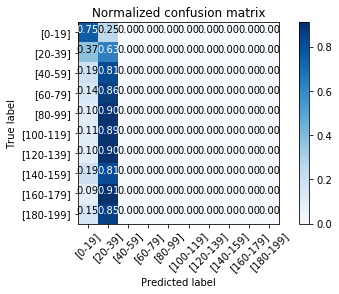

In [15]:
# Evaluate model
print(grid.best_params_)
# Accuracy
print(np.mean(predicted == y_test))
# Precision and Recall
print(metrics.classification_report(y_test, predicted))

# Plot Confusion Matrix
cnf_matrix = confusion_matrix(y_test, predicted, labels=[0,1,2,3,4,5,6,7,8,9])
plot_confusion_matrix(cnf_matrix, classes=['[0-19]', '[20-39]', '[40-59]', '[60-79]', '[80-99]', '[100-119]', '[120-139]', '[140-159]', '[160-179]', '[180-199]'], normalize=True,
                      title='Normalized confusion matrix')

### Results of predicting price using a SGD Logistic Regression classifier
* Accuracy: 51.8%
* The overall accuracy is lower for the SGD classifier than for the Multinomial Naive Bayes classifier
* Precision, recall, and F1 score are still generally higher for the lower price buckets
* The SGD classifier is also unable to predict the price buckets of higher priced wines

## Keras Classifier

The simpler classification models yield accuracies of around 55%. In order to improve upon this, we use more complex models, such as neural networks. Once again, we use a count vectorizer and a TF-IDF transformer to convert our data into vector form. First, we build a simple neural network with 9 hidden layers for classification. We use RMSProp as our optimizer and Categorical Cross Entropy for our loss function. We evaluate our model using KFold Cross Validation as well as, precision, recall, and F1 Score. 

In [41]:
norm_pipeline = Pipeline([('vect', CountVectorizer()),
                          ('tfidf', TfidfTransformer())
                         ])

X_norm = norm_pipeline.fit_transform(X)

In [63]:
from keras.layers.recurrent import LSTM
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate

# Set model hyperparameters
dropout = 0.05
num_features = X_norm.shape[1]
num_classes = len(set(y))
num_hidden_layers = 8
hidden_layer_size = 100

# Define simple neural network with 9 hidden layers
def create_model():
    model = Sequential()
    model.add(Dense(hidden_layer_size, input_shape=(X_norm.shape[1],), activation='tanh'))
    for layer in range(num_hidden_layers):
        model.add(Dropout(dropout))
        model.add(Dense(hidden_layer_size, activation='tanh'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

keras_model = KerasClassifier(build_fn=create_model)

In [43]:
# Perform KFold Cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True)
scoring = ['precision_macro', 'recall_macro', 'f1_macro']
scores = cross_validate(keras_model, X_norm, y, scoring=scoring, cv=kfold)

Epoch 1/1
109091/109091 [==============================] - 208s 2ms/step - loss: 1.1451 - acc: 0.5400
Epoch 1/1
109093/109093 [==============================] - 211s 2ms/step - loss: 1.1428 - acc: 0.5413
Epoch 1/1
109094/109094 [==============================] - 198s 2ms/step - loss: 1.1433 - acc: 0.5403
Epoch 1/1
109096/109096 [==============================] - 218s 2ms/step - loss: 1.1464 - acc: 0.5424
Epoch 1/1
109098/109098 [==============================] - 222s 2ms/step - loss: 1.1462 - acc: 0.5400


In [45]:
# Evaluate model using precision, recall, and F1 score
print("Precision", scores['test_precision_macro'])
print("Recall", scores['test_recall_macro'])
print("F1 Score", scores['test_f1_macro'])

Precision [0.1736783  0.14086129 0.21184706 0.15646347 0.19254899]
Recall [0.19315636 0.15491017 0.17066654 0.17938996 0.19070933]
F1 Score [0.18063026 0.14276364 0.16308799 0.16615164 0.18905104]


### Results of predicting price using a Keras Classifier
* Accuracy: ~55%
* No significant improvement over Multinomial Naive Bayes or SGD, in terms of accuracy
* Precision, Recall, and F1 Score reveal that the Keras Classifier predicts higher priced wines with some degree of accuracy

## LSTM with Word Embeddings

Now, we build a neural network with LSTM and Word Embeddings generated using Word2Vec. In theory, the word embeddings should help our model learn semantic meaning in the textual descriptions, which may improve prediction accuracy. Once again, we use RMSProp as our optimizer and Categorical Cross Entropy for our loss function. We evaluate our model by calculating accuracy on the test set.

In [65]:
from gensim.models import KeyedVectors
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Input, Embedding, Activation
from keras.optimizers import RMSprop

In [78]:
# Convert labels to categorical variables and split data into train and test sets
le = LabelEncoder()
y_transform = le.fit_transform(y)
y_cat = to_categorical(y_transform)
X_train,X_test,y_train,y_test = train_test_split(X,y_cat,test_size=0.15)

In [79]:
# Generate sequences matrix from descriptions
max_words = 500
max_len = 300
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

In [53]:
# Load word vectors
wv = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)

In [54]:
# Generate embedding matrix
word_index = tok.word_index
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    try:
        embedding_vector = wv.get_vector(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except:
        pass

In [80]:
# Define neural network with embedding layer and LSTM layer
def LSTM_Embed():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(
        len(word_index) + 1,
        300,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False
    )(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(10,name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [81]:
# Train model
lstm_embed = LSTM_Embed()
lstm_embed.summary()
lstm_embed.compile(loss='categorical_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
lstm_embed.fit(sequences_matrix,y_train,batch_size=128,epochs=10,
          validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 300)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 300, 300)          8145600   
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                93440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_13 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 10)                2570      
__________

In [82]:
# Evaluate model accuracy
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
accr = lstm_embed.evaluate(test_sequences_matrix, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

20456/20456 [==============================] - 92s 5ms/step
Test set
  Loss: 1.155
  Accuracy: 0.525


### Results of predicting price using a LSTM with Word Embeddings
* Accuracy: 52.5%
* Unfortunately, using a neural network with an LSTM layer and word embeddings generated from Word2Vec actually yielded a lower accuracy than using the Multinomal Naive Bayes classifier

## Overall Results of Predicting Price from Descriptions 
* The task of predicting price using textual descriptions of wines appears to be a relatively difficult one
* First, we tested simple classifiers, such as Multinomial Naive Bayes and SVM
* Next, we tested more complex classifiers built with Keras, one of which included an LSTM layer and word embeddings generated with Word2Vec
* We found that the more complex classifiers produced similar results as the simple ones
* The best model in terms of accuracy was the Multinomial Naive Bayes classifier

In [87]:
from sklearn.externals import joblib

# Pickle the multinomial naive bayes classifier with best parameters from GridSearchCV
naive_bayes_pipeline = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB(alpha=1.0, fit_prior=False)),
                    ])

naive_bayes_pipeline.fit(X, y)
filename = './models/wine_price_classifier.joblib.pkl'
joblib.dump(naive_bayes_pipeline, filename, compress=9)

['./models/wine_price_classifier.joblib.pkl']

# Predicting Quality from Description

Now, we move on to the task of predcting wine quality from textual descriptions. Since WineMag only publishes wines that score above 80/100 on the points scale, we normalize the points by subtracting 80 from all of the scores and generate the following quality buckets {(0-3), (4-7), (8-11), (12-15), (16-19)}. We test the same set of models as used previously.

In [83]:
# Splice points into buckets
lower_price_df['points_bucket'] = (lower_price_df['points'] - 80) // 4
lower_price_df['points_bucket'] = lower_price_df['points_bucket'].astype(int)

In [84]:
# Split data into training and test sets
X = lower_price_df['cleaned_descriptions']
y = lower_price_df['points_bucket']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Multinomial Naive Bayes Classifier

In [85]:
# Define Multinomial Naive Bayes Classifer and tune hyper parameters using GridSearch CV
naive_bayes_pipeline = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                    ])

param_grid = [
    {
        'clf__alpha': [0.5, 1.0],
        'clf__fit_prior': [True, False],
    }
]

grid = GridSearchCV(naive_bayes_pipeline, cv=3, n_jobs=1, param_grid=param_grid)
grid.fit(X_train, y_train)
predicted = grid.predict(X_test)

{'clf__alpha': 0.5, 'clf__fit_prior': False}
0.6555203566819195
             precision    recall  f1-score   support

          0       0.62      0.66      0.64      3010
          1       0.72      0.69      0.70     13899
          2       0.65      0.63      0.64     12679
          3       0.53      0.64      0.58      4293
          4       0.10      0.00      0.01       211
          5       0.00      0.00      0.00         0

avg / total       0.66      0.66      0.66     34092



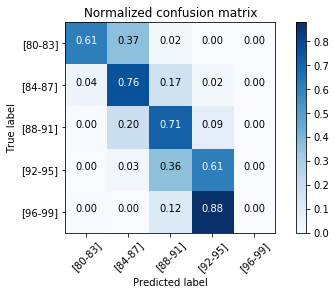

In [89]:
# Evaluate model
print(grid.best_params_)
# Accuracy
print(np.mean(predicted == y_test))
# Precision and Recall
print(metrics.classification_report(y_test, predicted))

# Plot confusion matrix
prediction = naive_bayes_pipeline.predict(X_test)
cnf_matrix = confusion_matrix(y_test, prediction, labels=[0,1,2,3,4])
plot_confusion_matrix(cnf_matrix, classes=['[80-83]', '[84-87]', '[88-91]', '[92-95]', '[96-99]'], normalize=True,
                      title='Normalized confusion matrix')

### Results of predicting quality using a Multinomial Naive Bayes classifier
* Accuracy: 65.5%
* The overall accuracy for predicting quality using the Multinomial Naive Bayes classifier is higher than the accuracies of predicting price using either classifier
* For predicting quality, the classifer does a better job of predicting higher buckets than for price

## Stochastic Gradient Descent Classifier

In [90]:
# Define SGD classifier and tune hyper parameters using GridSearchCV
sgd_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(random_state=42, tol=None, max_iter=5, loss='hinge')),
])

param_grid = [
    {
        'clf__penalty': ['l2', 'elasticnet'],
        'clf__alpha': [0.001, 0.01]
    }
]

grid = GridSearchCV(sgd_pipeline, cv=3, n_jobs=1, param_grid=param_grid)
grid.fit(X_train, y_train)
predicted = grid.predict(X_test)

{'clf__alpha': 0.001, 'clf__penalty': 'l2'}
0.5723630177167663
             precision    recall  f1-score   support

          0       0.86      0.08      0.15      3010
          1       0.56      0.90      0.69     13899
          2       0.57      0.51      0.54     12679
          3       0.73      0.08      0.14      4293
          4       0.00      0.00      0.00       211

avg / total       0.61      0.57      0.51     34092



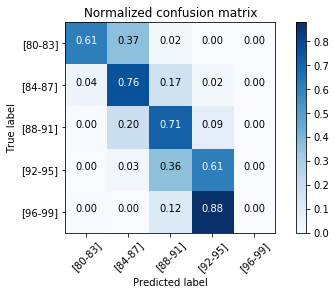

In [91]:
# Evaluate model
print(grid.best_params_)
# Accuracy
print(np.mean(predicted == y_test))
# Precision and Recall
print(metrics.classification_report(y_test, predicted))

# Plot confusion matrix
prediction = naive_bayes_pipeline.predict(X_test)
cnf_matrix = confusion_matrix(y_test, prediction, labels=[0,1,2,3,4])
plot_confusion_matrix(cnf_matrix, classes=['[80-83]', '[84-87]', '[88-91]', '[92-95]', '[96-99]'], normalize=True,
                      title='Normalized confusion matrix')

### Results of predicting quality using an Stochastic Gradient Descent classifier
* Accuracy: 57.01%
* The overall accuracy for predicting quality using the SGD classifier is higher than the accuracies of predicting price using either classifier
* Accuracy, Precision, recall, and F1 score are lower than those of the Multinomial Naive Bayes classifier

## Keras Classifier

In [93]:
norm_pipeline = Pipeline([('vect', CountVectorizer()),
                          ('tfidf', TfidfTransformer())
                         ])

X_norm = norm_pipeline.fit_transform(X)

In [94]:
# Set model hyperparameters
dropout = 0.05
num_features = X_norm.shape[1]
num_classes = len(set(y))
num_hidden_layers = 8
hidden_layer_size = 100

# Define model
def create_model():
    model = Sequential()
    model.add(Dense(hidden_layer_size, input_shape=(X_norm.shape[1],), activation='tanh'))
    for layer in range(num_hidden_layers):
        model.add(Dropout(dropout))
        model.add(Dense(hidden_layer_size, activation='tanh'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

keras_model = KerasClassifier(build_fn=create_model)

In [95]:
# Perform KFold Cross Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True)
scoring = ['precision_macro', 'recall_macro', 'f1_macro']
scores = cross_validate(keras_model, X_norm, y, scoring=scoring, cv=kfold)

Epoch 1/1
109092/109092 [==============================] - 221s 2ms/step - loss: 0.8069 - acc: 0.6459
Epoch 1/1
109093/109093 [==============================] - 199s 2ms/step - loss: 0.8049 - acc: 0.6475
Epoch 1/1
109095/109095 [==============================] - 220s 2ms/step - loss: 0.8091 - acc: 0.6439
Epoch 1/1
109096/109096 [==============================] - 214s 2ms/step - loss: 0.8055 - acc: 0.6451
Epoch 1/1
109096/109096 [==============================] - 207s 2ms/step - loss: 0.8073 - acc: 0.6472


In [97]:
# Evaluate model using Precision, Recall, and F1 Score
print("Precision", scores['test_precision_macro'])
print("Recall", scores['test_recall_macro'])
print("F1 Score", scores['test_f1_macro'])

Precision [0.43289077 0.45152082 0.46386963 0.45914539 0.51133267]
Recall [0.39499217 0.44753438 0.35858107 0.41184016 0.44358219]
F1 Score [0.39473947 0.4460784  0.37843197 0.42221926 0.4588866 ]


### Results of predicting quality using a Keras classifier
* The accuracy of the keras classifier is similar to that of the Multinomial Naive Bayes classifier
* Additionally, the Precision, Recall, and F1 scores are also comparable
* There is no significant improvement gained from using a more complex classifier

# LSTM with Word Embeddings

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Activation, Dense, Dropout, Input, Embedding
from keras.layers.recurrent import LSTM
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

In [100]:
# Encode labels as categorical variables and split data into train and test sets
le = LabelEncoder()
y_transform = le.fit_transform(y)
y_cat = to_categorical(y_transform)
X_train,X_test,y_train,y_test = train_test_split(X,y_cat,test_size=0.15)

In [101]:
# Create sequences matrix from descriptions
max_words = 500
max_len = 300
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [102]:
# Load word vectors
wv = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)

In [103]:
# Generate embedding matrix
word_index = tok.word_index
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    try:
        embedding_vector = wv.get_vector(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    except:
        pass

In [104]:
# Define model with embedding layer and LSTM layer
def LSTM_Qual():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(
        len(word_index) + 1,
        300,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False
    )(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(6,name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [105]:
# Train model
lstm_qual = LSTM_Qual()
lstm_qual.summary()
lstm_qual.compile(loss='categorical_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
lstm_qual.fit(sequences_matrix,y_train,batch_size=128,epochs=10,
          validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 300)               0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 300, 300)          8395500   
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                93440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_15 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_104 (Dropout)        (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 6)                 1542      
__________

In [106]:
# Evaluate model
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
accr = lstm_qual.evaluate(test_sequences_matrix, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

20456/20456 [==============================] - 87s 4ms/step
Test set
  Loss: 0.772
  Accuracy: 0.665


### Results of predicting quality using a LSTM with Word Embeddings
* Predicting quality using a neural network with LSTM and word embeddings generated from Word2Vec did not yield significant improvement from a simple multinomial naive bayes classifier 

## Overall Results of Predicting Quality from Descriptions
* We achieved higher accuracy, precision, recall, and F1 scores overall when predicting quality compared to predicting price
* However, we found that using more complex classifiers didn't necessarily improve classification performance

In [98]:
from sklearn.externals import joblib

naive_bayes_pipeline = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB(alpha=0.5, fit_prior=False)),
                    ])
# Save Multinomial Naive Bayes classifier for predicting quality
naive_bayes_pipeline.fit(X, y)
filename = './models/wine_qual_classifier.joblib.pkl'
joblib.dump(naive_bayes_pipeline, filename, compress=9)

['./models/wine_qual_classifier.joblib.pkl']